In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys,json,os
sys.path.append('../..')
import Project.profiles as pp
import Project.new_profiles as pnp
from Project.constants import Constants as pc
import Project.quadrantHopping as qH
from tqdm.notebook import tqdm
from iminuit import Minuit

In [2]:
class Sidm:
    def __init__(self,**kwargs):
        if 'lm' and 'rs' in kwargs.keys():
            key = 'nfw_to_iso'
            self.lm, self.rs = kwargs.get('lm'),kwargs.get('rs')
            self.ρs = pp.rho0_nfw(self.lm,self.rs)
        elif 'ρ0' and 'σ0' in kwargs.keys():
            key = 'iso_to_nfw'
            self.ρ0,self.σ0 = kwargs.get('ρ0'),kwargs.get('σ0')
        else:
            print ('Please give any one there paris: (lm,rs),(ρ0,σ0)')
    
        self.lmstar = kwargs.get('lmstar') if 'lmstar' in kwargs.keys() else 0
        self.rdstar = kwargs.get('rdstar') if 'rdstar' in kwargs.keys() else 1
        self.Σ0star = 10**(self.lmstar)/(2*np.pi*self.rdstar**2) if self.lmstar else 0
        
        self.tage = kwargs.get('tage') if 'tage' in kwargs.keys() else 10.
        self.σbym = kwargs.get('σbym') if 'σbym' in kwargs.keys() else 3.
        self.unit = 1e-10 * pc.Gyr * pc.yr * 1e3 * pc.M_sun / pc.kpc**3
        self.r = np.logspace(-2,3,400)
        
        if key == 'nfw_to_iso': self.iso_from_nfw()
        elif key == 'iso_to_nfw': self.nfw_from_iso()
        
        
    def ρ_bary(self,r):
        return self.Σ0star*np.exp(-r/self.rdstar)/(2*r)
    
    def ρ_nfw(self,r,**kwargs):
        ρs = kwargs.get('ρs') if 'ρs' in kwargs.keys() else self.ρs
        rs = kwargs.get('rs') if 'rs' in kwargs.keys() else self.rs
        return ρs/((r/rs)*(1 + (r/rs))**2)
    
    def ρ_iso(self,r,**kwargs):
        ρ0 = kwargs.get('ρ0') if 'ρ0' in kwargs.keys() else self.ρ0
        σ0 = kwargs.get('σ0') if 'σ0' in kwargs.keys() else self.σ0
        Φf = kwargs.get('Φf') if 'Φf' in kwargs.keys() else self.Φf
        return ρ0*np.exp(-Φf(r)/σ0**2)
    
    def ρ_kap(self,r):
        single = False
        if isinstance(r,(float,int)): r,single = [r],True
        ρ = np.zeros(len(r))
        for i in range(len(r)):
            if r[i] < self.r1: ρ[i] = self.ρ_iso(r[i])
            else: ρ[i] = self.ρ_nfw(r[i])
        if single: return ρ[0]
        else: return ρ
    
    def M_nfw(self,r,**kwargs):
        ρs = kwargs.get('ρs') if 'ρs' in kwargs.keys() else self.ρs
        rs = kwargs.get('rs') if 'rs' in kwargs.keys() else self.rs
        return 4*np.pi*ρs*(rs**3)*(np.log((r+rs)/rs) - (r/(r+rs)))
        
    def M_iso(self,r,**kwargs):
        ρ0 = kwargs.get('ρ0') if 'ρ0' in kwargs.keys() else self.ρ0
        σ0 = kwargs.get('σ0') if 'σ0' in kwargs.keys() else self.σ0
        Φf = kwargs.get('Φf') if 'Φf' in kwargs.keys() else self.Φf
        single = False
        if isinstance(r, (float,int)): r,single = [r],True
        M = np.zeros(len(r))
        for i in range(len(r)):
            r_ = np.logspace(-2,np.log10(r[i]),400)
            M[i] = 4*np.pi*np.trapz(self.ρ_iso(r_,ρ0 = ρ0,σ0 = σ0,Φf = Φf)*r_**2,r_)
        if single: return M[0]
        else: return M
    
    def M_kap(self,r):
        single = False
        if isinstance(r,(float,int)): r,single = [r],True
        M = np.zeros(len(r))
        for i in range(len(r)):
            if r[i] < self.r1: M[i] = self.M_iso(r[i])
            else: M[i] = self.M_nfw(r[i])
        if single: return M[0]
        else: return M
    
    def Φ_tot(self,**kwargs):
        ρ0 = kwargs.get('ρ0') if 'ρ0' in kwargs.keys() else self.ρ0
        σ0 = kwargs.get('σ0') if 'σ0' in kwargs.keys() else self.σ0
        def f(u,r):
            k1 = 4*np.pi*pc.G
            k2 = 4*np.pi*pc.G*ρ0
            t1 = k1*(self.ρ_bary(r))
            t2 = 2*u[1]/r
            t3 = k2*np.exp(-u[0]/σ0**2)
            return (u[1],t1-t2+t3)
        us = sp.integrate.odeint(f,[0,0],self.r)
        return us[:,0]
    
        
    def get_r1(self,**kwargs):
        ρ0 = kwargs.get('ρ0') if 'ρ0' in kwargs.keys() else self.ρ0
        σ0 = kwargs.get('σ0') if 'σ0' in kwargs.keys() else self.σ0
        Φf = kwargs.get('Φf') if 'Φf' in kwargs.keys() else self.Φf
        ρ1 = np.sqrt(np.pi)/(self.tage*self.σbym*4*σ0) / self.unit
        def solve_r1(lr1):
            r1 = 10**lr1
            return np.abs(np.log10(self.ρ_iso(r1,ρ0=ρ0,σ0=σ0,Φf=Φf))-np.log10(ρ1))/np.log10(ρ1)
        m_r1 = Minuit(solve_r1,lr1 = 1)
        m_r1.limits['lr1'] = (-1,np.log10(200))
        m_r1.errordef = Minuit.LIKELIHOOD
        min_res,m_r1 = qH.quadhop(m_r1,['lr1'],[1])
        return 10**min_res['globalmin'][0]
    
    def nfw_from_iso(self):
        self.Φf = sp.interpolate.interp1d(self.r,self.Φ_tot(),kind = 'cubic', fill_value = 'extrapolate')
        self.r1 = self.get_r1()
        self.ρ1 = self.ρ_iso(self.r1)
        self.M1 = self.M_iso(self.r1)
        ρs_func = lambda rs_: self.ρ1 * (self.r1/rs_) * (1+(self.r1/rs_))**2
        def solve_rs(x):
            return np.abs(np.log10(self.M_nfw(ρs = ρs_func(x),rs=x,r=self.r1)) - np.log10(self.M1))/np.log10(self.M1)
        m_rs = Minuit(solve_rs,x = 1)
        m_rs.limits['x'] = (0.1,200)
        m_rs.errordef = Minuit.LIKELIHOOD
        min_res,m = qH.quadhop(m_rs,['x'],[1])
        self.min_res = min_res
        self.rs = min_res['globalmin'][0]
        self.ρs = ρs_func(self.rs)
        def solve_lm(x):
            r200 = pp.r200_nfw(x)
            m200 = self.M_nfw(r200)
            return np.abs(np.log10(m200)-np.log10(pp.mass_nfw(x,self.rs,r200)))/np.log10(m200)
        m_lm = Minuit(solve_lm,x = 10)
        m_lm.limits['x'] = (7,14)
        m_lm.errordef = Minuit.LIKELIHOOD
        min_res,m = qH.quadhop(m_lm,['x'],[10])
        self.lm = min_res['globalmin'][0]
        
    def iso_from_nfw(self):
        def solve_iso(lρ0,lσ0):
            ρ0 = 10**lρ0
            σ0 = 10**lσ0
            Φf = sp.interpolate.interp1d(self.r,self.Φ_tot(ρ0=ρ0,σ0=σ0),kind='cubic',fill_value='extrapolate')
            r1 = self.get_r1(ρ0=ρ0,σ0=σ0,Φf=Φf)
            M1_nfw = self.M_nfw(r1)
            M1_iso = self.M_iso(r1,ρ0=ρ0,σ0=σ0,Φf=Φf)
            ρ1_nfw = self.ρ_nfw(r1)
            ρ1_iso = self.ρ_iso(r1,ρ0=ρ0,σ0=σ0,Φf=Φf)
            return np.abs(np.log10(M1_nfw)-np.log10(M1_iso))/np.log10(M1_nfw) + np.abs(np.log10(ρ1_nfw)-np.log10(ρ1_iso))/np.log10(ρ1_nfw)
        tol = 1e-2
        guess = [7,2]
        while tol > 1e-3:
            m = Minuit(solve_iso,lρ0=guess[0],lσ0=guess[1])
            m.limits['lρ0'] = [np.log10(5e6),11]
            m.limits['lσ0'] = [1,np.log10(500)]
            m.errordef = Minuit.LIKELIHOOD
            min_res,m = qH.quadhop(m,['lρ0','lσ0'],guess)
            guess = min_res['globalmin']
            tol = min_res['globalfun']
        self.min_res = min_res
        self.ρ0 = 10**min_res['globalmin'][0]
        self.σ0 = 10**min_res['globalmin'][1]
        self.Φf = sp.interpolate.interp1d(self.r,self.Φ_tot(),kind='cubic',fill_value='extrapolate')
        self.r1 = self.get_r1()
        self.ρ1 = self.ρ_nfw(self.r1)
        self.M1 = self.M_nfw(self.r1)
        
    def print_results(self,full = False):
        print ('logρ0 = %.2f'%np.log10(self.ρ0))
        print ('σ_v0  = %.2f'%self.σ0)
        print ('r1    = %.2f'%self.r1)
        print ('rs    = %.2f'%self.rs)
        print ('lM200 = %.2f'%self.lm)
        print ('r200  = %.2f'%(pp.r200_nfw(self.lm)))
        if full:
            print ('logρs = %.2f'%np.log10(self.ρs))
            print ('σ/m   = %.2f'%self.σbym)
            print ('logM1 = %.2f'%np.log10(self.M1))
            print ('logρ1 = %.2f'%np.log10(self.ρ1))
            print ('logM_s= %.2f'%self.lmstar)
            print ('Rd_s  = %.2f'%self.rdstar)
            lsig = np.log10(self.Σ0star) if self.Σ0star else 0
            print ('logΣ0 = %.2f'%lsig)
            
    def v_nfw(self,r):
        return np.sqrt(pc.G*self.M_nfw(r)/r)
    
    def v_kap(self,r):
        return np.sqrt(pc.G*self.M_kap(r)/r)
            
    def plot_density(self,label = '', c = 'k',ax = None):
        if not ax:
            fig,ax = plt.subplots()
        ax.plot(self.r,self.ρ_kap(self.r), c = c, label = 'SIDM_%s'%label)
        ax.plot(self.r,self.ρ_nfw(self.r), c = c, label = 'NFW_%s'%label, ls = '--')
        ax.scatter(self.r1,self.ρ1, c = c, marker = '.', s = 200)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.legend()
        return ax
        
    def plot_velocity(self,label = '',c = 'k',ax = None):
        if not ax:
            fig,ax = plt.subplots()
        ax.plot(self.r,self.v_kap(self.r),c = c, label = 'SIDM_%s'%label)
        ax.plot(self.r,self.v_nfw(self.r),c = c, label = 'NFW_%s'%label, ls = '--')
        ax.scatter(self.r1,self.v_kap(self.r1),c = c, marker = '.', s = 200)
        ax.set_xlim(0,100)
        ax.legend()
        return ax

In [3]:
LM = np.linspace(9.,13.5,10)
LS = pnp.lmstar_behroozi_19(LM)
C2 = 10**pp.lc200_SR(LM)
RD = 10**(0.28*LS - 2.40)

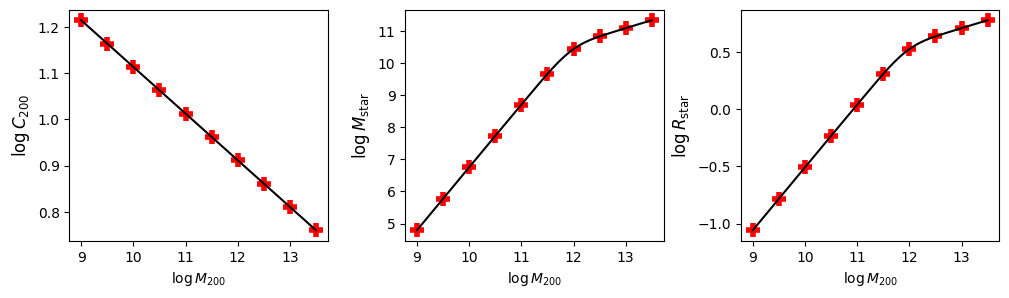

In [4]:
fig,axs = plt.subplots(1,3,figsize = (12,3), gridspec_kw = {'wspace':0.3})
ax1,ax2,ax3 = axs
lm = np.linspace(9.,13.5,100)
ax1.plot(lm,pp.lc200_SR(lm),c = 'k')
ax1.scatter(LM,np.log10(C2),marker = '+', s = 100, lw = 4, c = 'r')
ax1.set_ylabel('$\mathrm{log}\,C_{200}$',size = 12)

ax2.plot(lm,pnp.lmstar_behroozi_19(lm), c = 'k')
ax2.scatter(LM,LS,marker = '+', s = 100,lw = 4,c = 'r')
ax2.set_ylabel('$\mathrm{log}\,M_{\mathrm{star}}$',size = 12)

ax3.plot(lm,(0.28*pnp.lmstar_behroozi_19(lm)-2.4), c = 'k')
ax3.scatter(LM,np.log10(RD),marker = '+', s = 100, lw = 4, c = 'r')
ax3.set_ylabel('$\mathrm{log}\,R_{\mathrm{star}}$',size = 12)

for ax in axs:
    ax.set_xlabel('$\mathrm{log}\,M_{200}$')

In [8]:
sidms = []
for i in tqdm(range(10)):
    s = Sidm(lm = LM[i], rs = pp.r200_nfw(LM[i])/C2[i], lmstar = LS[i], rdstar = RD[i])
    S = Sidm(ρ0 = s.ρ0, σ0 = s.σ0, lmstar = s.lmstar, rdstar = s.rdstar)
    sidms.append([s,S])

  0%|          | 0/10 [00:00<?, ?it/s]

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

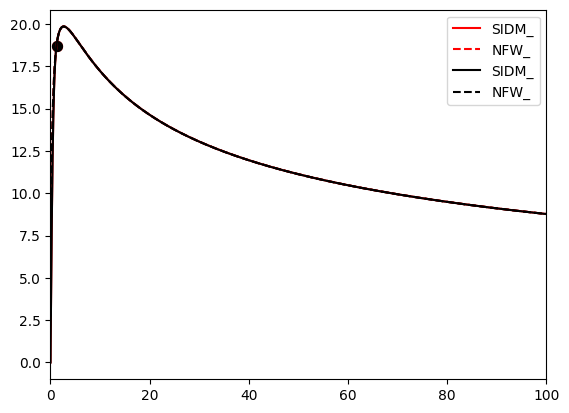

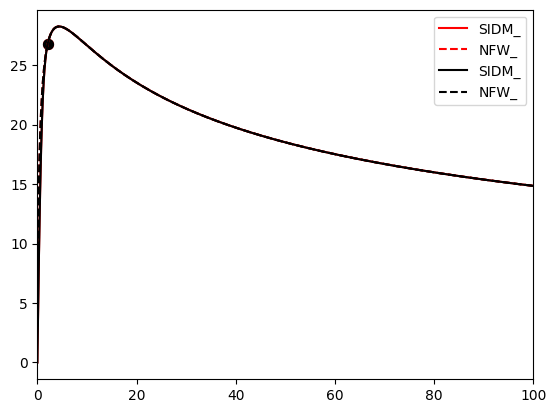

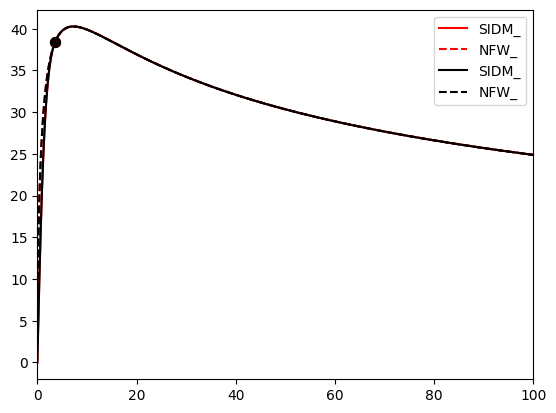

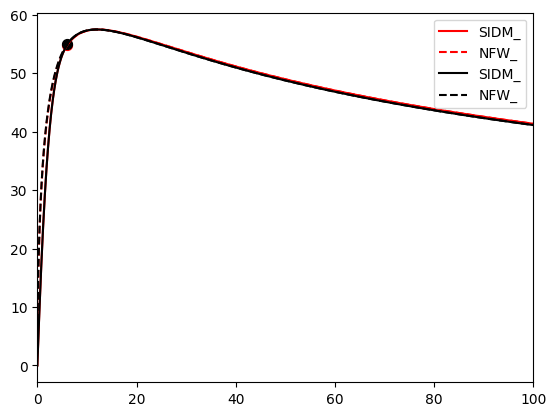

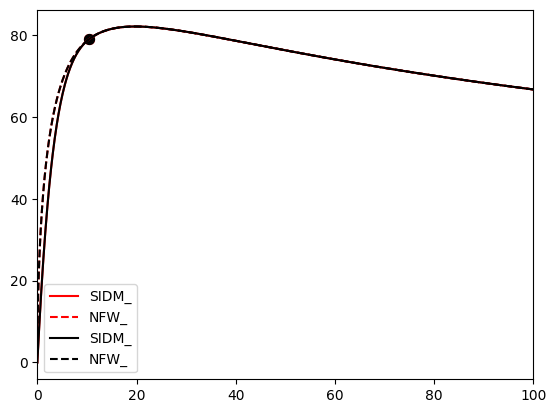

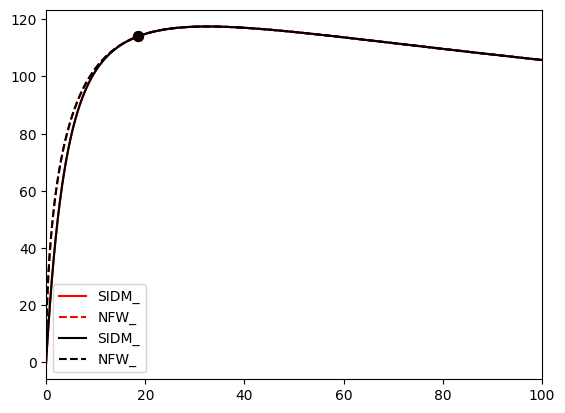

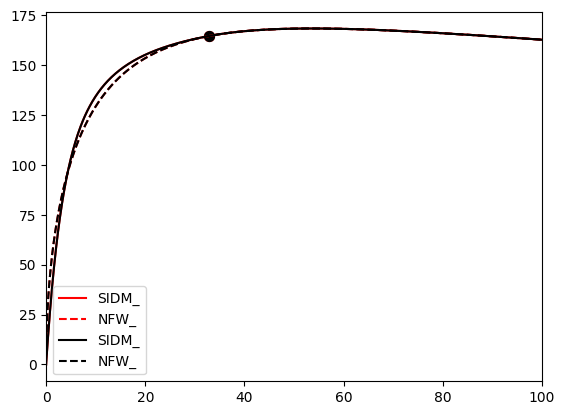

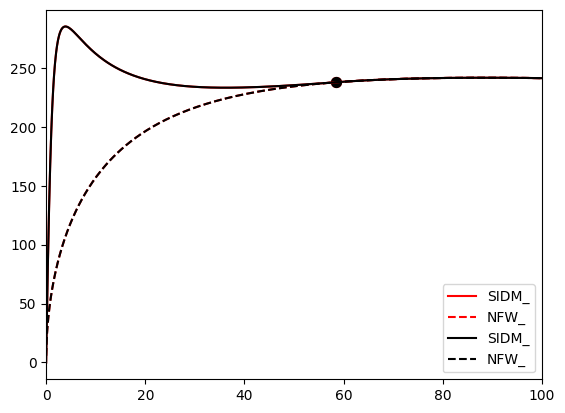

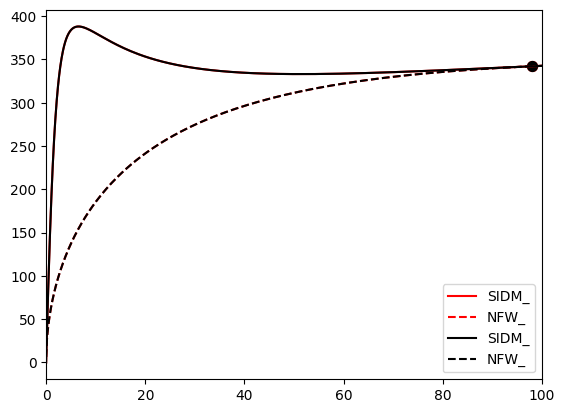

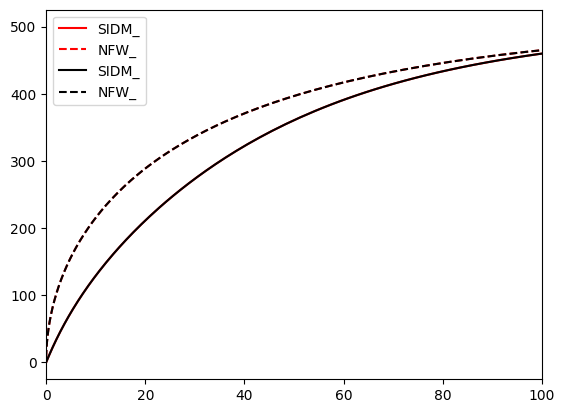

In [14]:
for i in range(10):
    s,S = sidms[i]
    # s.print_results()
    # S.print_results()
    # print ('********')
    ax = S.plot_velocity(c = 'r')
    s.plot_velocity(ax = ax, c = 'k')

logρ0 = 7.50
σ_v0  = 36.13
r1    = 6.07
rs    = 5.53
lM200 = 10.50
r200  = 63.96
********
logρ0 = 7.50
σ_v0  = 36.13
r1    = 6.07
rs    = 5.53
lM200 = 10.50
r200  = 63.96


<AxesSubplot: >

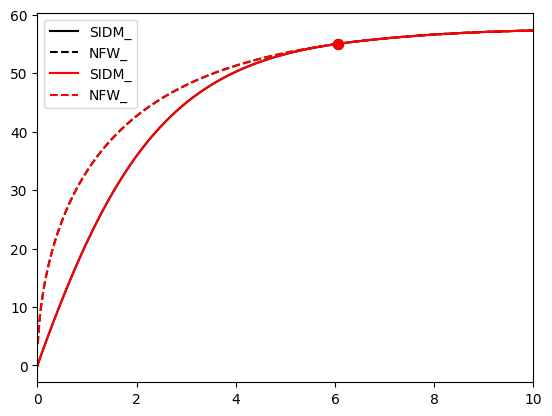

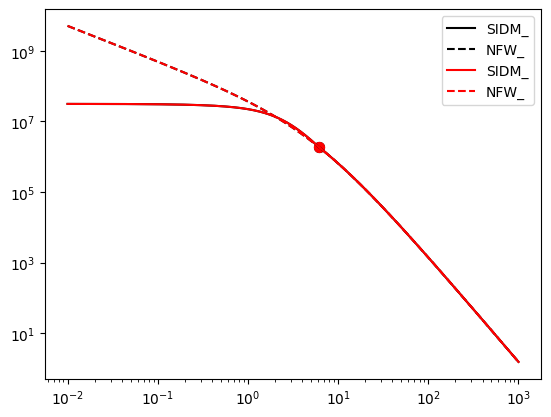

In [356]:
s.print_results()
print ('********')
S.print_results()
ax = s.plot_velocity()
S.plot_velocity(ax = ax, c = 'r')
ax.set_xlim(0,10)

ax = s.plot_density()
S.plot_density(ax = ax, c = 'r')

In [ ]:
            fun = np.array(min_res['fun'])
            idx = [np.where(fun == np.sort(np.abs(fun))[j])[0][0] for j in range(len(fun))]
            minima = min_res['minima']
            i = 0
            while (i >= 0) and (i < len(fun)):
                res = minima[idx[i]]
                tol = fun[idx[i]]
                if tol < 1e-2:
                    ρ0,σ0 = 10**res[0],10**res[1]
                    Φf = sp.interpolate.interp1d(self.r,self.Φ_tot(ρ0=ρ0,σ0=σ0),kind='cubic',fill_value='extrapolate')
                    r1 = self.get_r1(ρ0=ρ0,σ0=σ0,Φf=Φf)
                    if self.check_1(r1,ρ0,σ0,Φf): min_res['best_i'],i = i, -1
                    else: i,min_res['msg'],min_res['best_i'] = i+1,'first else',0
                else: min_res['best_i'],i,min_res['msg'] = i,-2,'last else'